<code>plot_SIE_SIE_anom_bias_init_month_vs_lead_time_FINAL.ipynb</code>.  Calculates bias ($ model - obs $) in SIE and SIE anom forecasts as a function of region, season, and lead time. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import os
import glob

1. Load raw error files for each model
2. Estimate lead weeks
3. Make following plots:
    *  <b>For each region</b>:
        *  <b>4-panel heat map of SIE bias with lead weeks (x) and init month (y); each panel is one model</b>
        *  <b>4-panel heat map of SIE anom bias with lead weeks (x) and init month (y); each panel is one model</b>


plot for heat map: init month vs lead time in DAYS for each model

Load S2S model errors

In [2]:
model_names_all = ['ecmwf','ukmo','ncep','metreofr']
model_names_plt = ['ecmwf','ukmo','ncep','meteofr']
seas_str = 'ALL'
week_length = 7
max_lead_week = 4

Load model errors into one dataframe

In [3]:
file_path_load = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/data/'

SIE_errors_ALL = pd.DataFrame()
for i_model in model_names_all:
    fload_i = file_path_load+'{i_model}/RAW_err_{i_model}_months{seas_str}_model_clim_freq_WEEKLY.csv'.format(i_model=i_model,
                                                                                        seas_str=seas_str)
    pd_load = pd.read_csv(fload_i)
    pd_load['model name'] = i_model
    SIE_errors_ALL = SIE_errors_ALL.append(pd_load)

Calculate lead time in weeks

In [4]:
SIE_errors_ALL['lead weeks'] = SIE_errors_ALL['lead days'].values.astype('timedelta64[D]')/pd.Timedelta(week_length,'D')
SIE_errors_ALL['lead weeks'] = SIE_errors_ALL['lead weeks'].apply(np.floor) 
SIE_errors_ALL

,region,valid date,lead days,init date,SIE,SIE anom,model name,lead weeks
0,Atlantic,1999-01-03,0,1999-01-03,-0.110369,0.199128,ecmwf,0.0
1,Atlantic,1999-01-04,1,1999-01-03,-0.076445,0.226029,ecmwf,0.0
2,Atlantic,1999-01-05,2,1999-01-03,-0.098926,0.194291,ecmwf,0.0
3,Atlantic,1999-01-06,3,1999-01-03,-0.103905,0.187650,ecmwf,0.0
4,Atlantic,1999-01-07,0,1999-01-07,-0.238176,0.079253,ecmwf,0.0
...,...,...,...,...,...,...,...,...
921595,panArctic,2015-02-15,55,2014-12-22,-1.311706,0.023388,metreofr,7.0
921596,panArctic,2015-02-16,56,2014-12-22,-1.168223,0.156649,metreofr,8.0
921597,panArctic,2015-02-17,57,2014-12-22,-1.140751,0.177740,metreofr,8.0
921598,panArctic,2015-02-18,58,2014-12-22,-1.139216,0.186333,metreofr,8.0


Trim to errors of interest.  Then, create a <code>Categorical</code> so that we can plot our results in the desired order.  Finally, replace certain region names for plotting (and <code>meteofr</code> as well)

In [5]:
regions_trim = ["panArctic","Central Arctic","East Siberian-Beaufort-Chukchi Sea","Kara-Laptev Sea","Barents Sea",
              "East Greenland Sea"]
SIE_errors_trim = SIE_errors_ALL[SIE_errors_ALL['region'].isin(regions_trim)]
SIE_errors_trim['region'] = SIE_errors_trim['region'].replace({'East Greenland Sea':'E. Greenland Sea',
    'East Siberian-Beaufort-Chukchi Sea':'E. Sib./Beauf./Chuk. Sea'})
#
regions_sel = ["panArctic","Central Arctic","E. Sib./Beauf./Chuk. Sea","Kara-Laptev Sea","Barents Sea",
              "E. Greenland Sea"]
SIE_errors_trim['region sort'] = pd.Categorical(SIE_errors_trim['region'],regions_sel)


SIE_errors_trim['model name'] = SIE_errors_trim['model name'].replace({'metreofr':'meteofr'})


/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is t

For regionally based plots, index by region, model name, init date, lead days

In [6]:
SIE_errors_trim['init month'] = pd.to_datetime(SIE_errors_trim['init date']).dt.month
SIE_errors_trim['valid month'] = pd.to_datetime(SIE_errors_trim['valid date']).dt.month
SIE_errors_regions_weeks = SIE_errors_trim.where(SIE_errors_trim['lead weeks']<max_lead_week).dropna(how='all')
SIE_errors_regions_weeks = SIE_errors_trim.set_index(['region sort'])
SIE_errors_regions_weeks

/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,region,valid date,lead days,init date,SIE,SIE anom,model name,lead weeks,init month,valid month
region sort,,,,,,,,,,
Barents Sea,Barents Sea,1999-01-03,0,1999-01-03,-0.092943,0.055106,ecmwf,0.0,1,1
Barents Sea,Barents Sea,1999-01-04,1,1999-01-03,-0.074074,0.077563,ecmwf,0.0,1,1
Barents Sea,Barents Sea,1999-01-05,2,1999-01-03,-0.106678,0.050193,ecmwf,0.0,1,1
Barents Sea,Barents Sea,1999-01-06,3,1999-01-03,-0.125206,0.036178,ecmwf,0.0,1,1
Barents Sea,Barents Sea,1999-01-07,0,1999-01-07,-0.103081,0.040407,ecmwf,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...
panArctic,panArctic,2015-02-15,55,2014-12-22,-1.311706,0.023388,meteofr,7.0,12,2
panArctic,panArctic,2015-02-16,56,2014-12-22,-1.168223,0.156649,meteofr,8.0,12,2
panArctic,panArctic,2015-02-17,57,2014-12-22,-1.140751,0.177740,meteofr,8.0,12,2


Set up plot parameters

In [7]:
save_type = 'pdf'
ANOM = False
if ANOM == True:
    save_str = 'SIE_anom'
    title_str = 'Anomalous Sea Ice Extent'
    [vmin,vmax] = [-0.05,0.05]
else:
    save_str = 'SIE'
    title_str = 'Sea Ice Extent'
    [vmin_0,vmax_0] = [-0.25,0]
no_models = len(model_names_all)
no_rows = np.int(len(model_names_all)/2)

Plot

Text(0.5, 0.98, 'Bias in Sea Ice Extent, Lead Weeks 1-4')

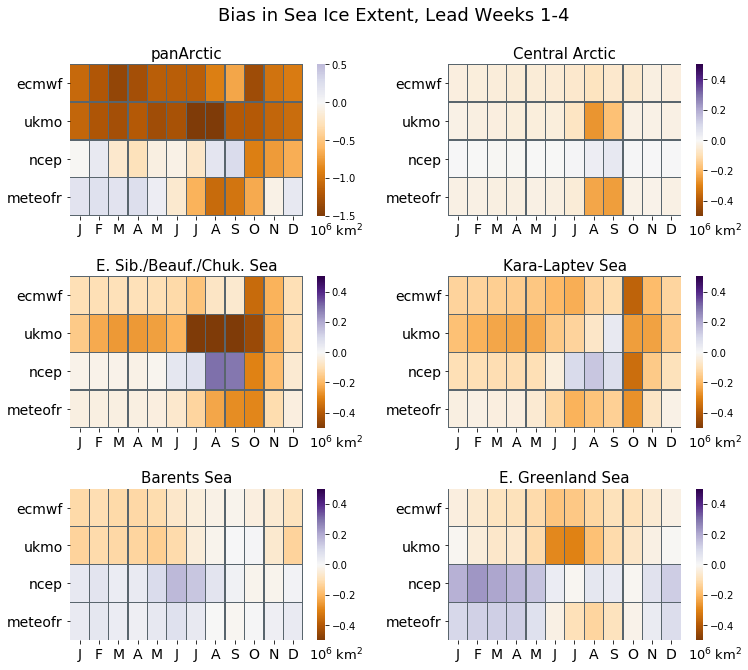

In [8]:
no_rows = 3
no_cols = 2
mon_labels = ['J','F','M','A','M','J','J','A','S','O','N','D']
fig1,ax = plt.subplots(no_rows,no_cols,figsize=(12,10))#,sharex=True,sharey=True)
for imod in np.arange(0,len(regions_sel)):
    region_sel = regions_sel[imod]
    plt_test = SIE_errors_regions_weeks.loc[region_sel]
    piv_plt = pd.pivot_table(data=plt_test,index='model name',columns='valid month',values='SIE',aggfunc=np.mean)
    #
    ax_sel = ax.flat[imod]
    #cbar_ax = fig.add_axes([.965,.3,.03,.4])
    if region_sel == 'panArctic':
        [vmin,vmax] = [-1.5,0.5]
    else:
        [vmin,vmax] = [-0.5,0.5]
    sns.heatmap(piv_plt,cmap = 'PuOr',ax=ax_sel,linewidth=0.2,linecolor='xkcd:slate grey',
                vmin=vmin,vmax=vmax,center=0)
    ax_sel.set_yticklabels(model_names_plt,rotation=0,fontsize=14)
    ax_sel.set_xticklabels(mon_labels,fontsize=14)
    ax_sel.set_ylabel(None)
    ax_sel.set_xlabel(None)
    ax_sel.set_title('{region}'.format(region=region_sel),fontsize=15)
    ax_sel.collections[0].colorbar.set_label('10$^6$ km$^2$',rotation=0,fontsize=13,y=-0.04,labelpad=-20)
    
#
fig1.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.4)
fig1.suptitle('Bias in Sea Ice Extent, Lead Weeks 1-{max_lead}'.format(max_lead=max_lead_week),fontsize=18)

In [9]:
fdir = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/figures/bias_S2S_minus_obs/'
if not os.path.exists(fdir):
    os.makedirs(fdir) 
fname_save = fdir+'SIE_bias_common_reforecast_max_lead_{max_lead}weeks.png'.format(max_lead=max_lead_week)
fig1.savefig(fname_save,format='png',dpi=500,bbox_inches='tight')

In [10]:
#
fdir_final = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/figures/Paper_Figures/'
fname_final = fdir_final+'bias_mean_SIE_max_lead_{max_lead}weeks.pdf'.format(max_lead=max_lead_week)

if max_lead_week == 4:
    fig1.savefig(fname_final,format='pdf',dpi=500,bbox_inches='tight')

Same but for anomalous SIE

Text(0.5, 0.98, 'Bias in Anomalous Sea Ice Extent, Lead Weeks 1-4')

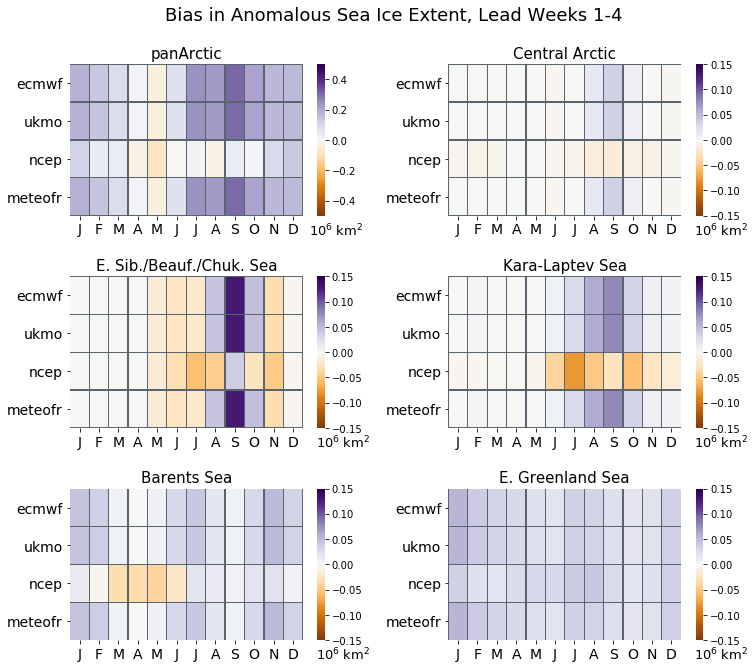

In [11]:
no_rows = 3
no_cols = 2
mon_labels = ['J','F','M','A','M','J','J','A','S','O','N','D']
fig2,ax2 = plt.subplots(no_rows,no_cols,figsize=(12,10))#,sharex=True,sharey=True)
for imod in np.arange(0,len(regions_sel)):
    region_sel = regions_sel[imod]
    plt_test = SIE_errors_regions_weeks.loc[region_sel]
    piv_plt = pd.pivot_table(data=plt_test,index='model name',columns='valid month',values='SIE anom',aggfunc=np.mean)
    #
    ax_sel = ax2.flat[imod]
    #cbar_ax = fig.add_axes([.965,.3,.03,.4])
    if region_sel == 'panArctic':
        [vmin,vmax] = [-0.5,0.5]
    else:
        [vmin,vmax] = [-0.15,0.15]
    sns.heatmap(piv_plt,cmap = 'PuOr',ax=ax_sel,linewidth=0.2,linecolor='xkcd:slate grey',
                vmin=vmin,vmax=vmax,center=0)
    ax_sel.set_yticklabels(model_names_plt,rotation=0,fontsize=14)
    ax_sel.set_xticklabels(mon_labels,fontsize=14)
    ax_sel.set_ylabel(None)
    ax_sel.set_xlabel(None)
    ax_sel.set_title('{region}'.format(region=region_sel),fontsize=15)
    ax_sel.collections[0].colorbar.set_label('10$^6$ km$^2$',rotation=0,fontsize=13,y=-0.04,labelpad=-20)
    
#
fig2.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.4)
fig2.suptitle('Bias in Anomalous Sea Ice Extent, Lead Weeks 1-{max_lead}'.format(max_lead=max_lead_week),fontsize=18)

In [12]:
fname2_save = fdir+'SIE_anom_bias_common_reforecast_max_lead_{max_lead}weeks.png'.format(max_lead=max_lead_week)
fig2.savefig(fname2_save,format='png',dpi=500,bbox_inches='tight')

In [13]:
fname2_final = fdir_final+'bias_mean_SIE_anom_max_lead_{max_lead}weeks.pdf'.format(max_lead=max_lead_week)
if max_lead_week == 4:
    fig2.savefig(fname2_final,format='pdf',dpi=500,bbox_inches='tight')